# Latency Comparison

In this section we collect results from measuring the latency between ingesting data from the source and collecting the data from the broker (i.e., Kafka vs NGSI-LD Broker).

First, execute the tests from Apache NiFi for each number of events to be sent to the broker every second. The results from these tests will be stored in `results/latency/<broker>/`.

## Building the Datasets

In [1]:
import pandas as pd

#Disable scientific notation in datasets
pd.set_option('display.float_format', lambda x: '%.3f' % x)

Set list with number events per second configured for each experiment.

In [60]:
events = [50,100,150]

### Scorpio

In [50]:
import glob

scorpio = []
for event in events:
    path = r'./results/latency/scorpio/%s' % event # use your path
    all_files = glob.glob(path + "/*")

    li = []

    for filename in all_files:
        df = pd.read_csv(filename, index_col=None, header=0)
        li.append(df)

    scorpio.append(pd.concat(li, axis=0, ignore_index=True))
    
# Estimate the delta between the collection and notification timestamps
scorpio_means = []
for table in scorpio:
    table["deltaTimestamp"] = table["notificationTimestamp"] - table["collectionTimestamp"]
    scorpio_means.append(table["deltaTimestamp"].mean())

### Orion-LD

In [61]:
import glob

orion = []
for event in events:
    path = r'./results/latency/orion/%s' % event # use your path
    all_files = glob.glob(path + "/*")

    li = []

    for filename in all_files:
        df = pd.read_csv(filename, index_col=None, header=0)
        li.append(df)

    orion.append(pd.concat(li, axis=0, ignore_index=True))
    
# Estimate the delta between the collection and notification timestamps
orion_means = []
for table in orion:
    table["deltaTimestamp"] = table["notificationTimestamp"] - table["collectionTimestamp"]
    orion_means.append(table["deltaTimestamp"].mean())

### Kafka-AVRO

In [62]:
import glob

kafka_avro = []
for event in events:
    path = r'./results/latency/kafka_avro/%s' % event # use your path
    all_files = glob.glob(path + "/*")

    li = []

    for filename in all_files:
        df = pd.read_csv(filename, index_col=None, header=0)
        li.append(df)

    kafka_avro.append(pd.concat(li, axis=0, ignore_index=True))

# Estimate the delta between the collection and notification timestamps
kafka_avro_means = []
for table in kafka_avro:
    table["deltaTimestamp"] = table["notificationTimestamp"] - table["collectionTimestamp"]
    kafka_avro_means.append(table["deltaTimestamp"].mean())

### Kafka-NGSI-LD

In [63]:
import glob

kafka_ngsi_ld = []
for event in events:
    path = r'./results/latency/kafka_ngsi-ld/%s' % event # use your path
    all_files = glob.glob(path + "/*")

    li = []

    for filename in all_files:
        df = pd.read_csv(filename, index_col=None, header=0)
        li.append(df)

    kafka_ngsi_ld.append(pd.concat(li, axis=0, ignore_index=True))

# Estimate the delta between the collection and notification timestamps
kafka_ngsi_ld_means = []
for table in kafka_ngsi_ld:
    table["deltaTimestamp"] = table["notificationTimestamp"] - table["collectionTimestamp"]
    kafka_ngsi_ld_means.append(table["deltaTimestamp"].mean())

## Visualization

Once the datasets haven prepared, move on to creating some plots.

In [83]:
import matplotlib.pyplot as plt
plt.close("all")

<AxesSubplot:xlabel='Events'>

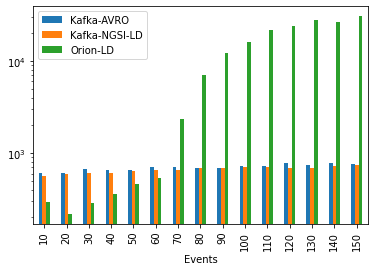

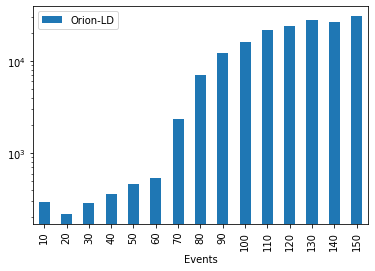

In [69]:
latency = pd.DataFrame({"Events": events,
                        "Kafka-AVRO": kafka_avro_means, "Kafka-NGSI-LD": kafka_ngsi_ld_means, 
                        "Orion-LD": orion_means})
latency.plot.bar(x="Events", logy=True)
latency = pd.DataFrame({"Events": events,"Orion-LD": orion_means})
latency.plot.bar(x="Events", logy=True)

<AxesSubplot:xlabel='Events'>

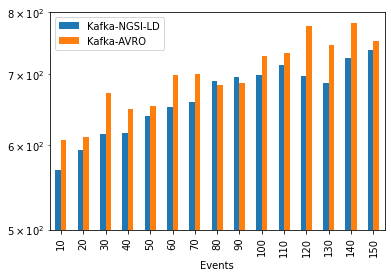

In [70]:
latency = pd.DataFrame({"Events": events,"Kafka-NGSI-LD": kafka_ngsi_ld_means, 
                        "Kafka-AVRO": kafka_avro_means })
latency.plot.bar(x="Events", ylim=(500,800))

# Container Performance

The following snippet produces docker stats and appends the results to a CSV file. For these validation tests, we collect the memory and CPU percentage usage:

```bash
while true; do docker stats <my_container> --no-stream --format "{{ .CPUPerc }},{{ .MemPerc }}" | tee --append results/cpu_memory/<my_container>/<my_container>_<events>.csv; sleep 1; done

while true; do docker stats db-mongo fiware-orion nifi --no-stream --format "{{ .Name }},{{ .CPUPerc }},{{ .MemPerc }}" | tee --append results/cpu_memory/orion/orion_50.csv; sleep 1; done
```

We collect results for each NGSI-LD Broker and for Kafka while running the latency tests. Make sure to specify the `events` value used for the latency tests.

You can also use the `collect_docker_stats.sh` utility. The following example collects CPU and memory percentage usage stats for kafka when 60 events are sent every second:

```bash
./collect_docker_stats.sh kafka 60
```

## Building the Datasets

Process the generated CSV files using panda. First remove the percentage character from the memory and CPU columns. Then generate two charts - memory and CPU - that compare Kafka container against each NGSI-LD Broker container.

### Scorpio

In [95]:
events = [50,100,150,200,250]
scorpio_services = []
for event in events:
    dataset_path = r'./results/cpu_memory/scorpio/scorpio_%s.csv' % event # use your path    
    table = pd.read_csv(dataset_path, index_col=0, 
                        header=0, names=["service", "cpu", "memory"])
    table['cpu'] = table['cpu'].str.rstrip('%').astype('float') / 100.0
    table['memory'] = table['memory'].str.rstrip('%').astype('float') / 100.0
    scorpio_services.append(table)

In [96]:
scorpio_cpu = {}
for table in scorpio_services:
    cpu_means = table.groupby("service").mean()["cpu"]
    for index,value in cpu_means.iteritems():
        if index not in scorpio_cpu:
            scorpio_cpu[index] = []
        scorpio_cpu[index].append(value)

<AxesSubplot:>

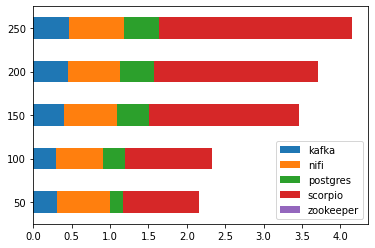

In [97]:
cpu = pd.DataFrame(scorpio_cpu, index=events)
cpu.plot.barh(stacked=True)

In [103]:
scorpio_mem = {}
for table in scorpio_services:
    mem_means = table.groupby("service").mean()["memory"]
    for index,value in mem_means.iteritems():
        if index not in scorpio_mem:
            scorpio_mem[index] = []
        scorpio_mem[index].append(value)

<AxesSubplot:>

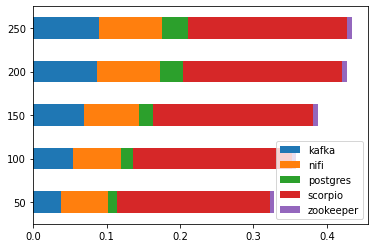

In [104]:
mem = pd.DataFrame(scorpio_mem, index=events)
mem.plot.barh(stacked=True)

### Orion-LD

In [98]:
events = [50,100,150,200,250]
orion_services = []
for event in events:
    dataset_path = r'./results/cpu_memory/orion/orion_%s.csv' % event # use your path    
    table = pd.read_csv(dataset_path, index_col=0, 
                        header=0, names=["service", "cpu", "memory"])
    table['cpu'] = table['cpu'].str.rstrip('%').astype('float') / 100.0
    table['memory'] = table['memory'].str.rstrip('%').astype('float') / 100.0
    orion_services.append(table)

In [99]:
orion_cpu = {}
for table in orion_services:
    cpu_means = table.groupby("service").mean()["cpu"]
    for index,value in cpu_means.iteritems():
        if index not in orion_cpu:
            orion_cpu[index] = []
        orion_cpu[index].append(value)

<AxesSubplot:>

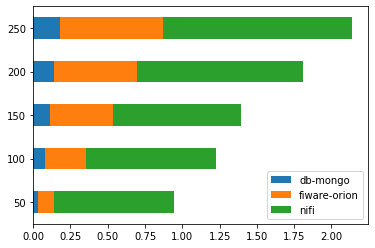

In [100]:
cpu = pd.DataFrame(orion_cpu, index=events)
cpu.plot.barh(stacked=True)

In [101]:
orion_mem = {}
for table in orion_services:
    mem_means = table.groupby("service").mean()["memory"]
    for index,value in mem_means.iteritems():
        if index not in orion_mem:
            orion_mem[index] = []
        orion_mem[index].append(value)

<AxesSubplot:>

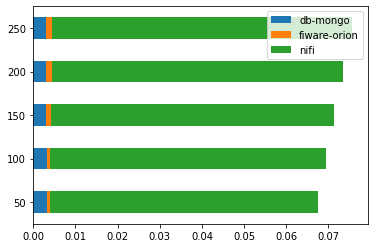

In [102]:
mem = pd.DataFrame(orion_mem, index=events)
mem.plot.barh(stacked=True)

### Kafka-AVRO

In [44]:
kafka_avro_cpu = []
kafka_avro_memory = []
for event in events:
    dataset_path = r'./results/cpu_memory/kafka_avro/kafka_%s.csv' % event # use your path    
    table = pd.read_csv(dataset_path, index_col=None, 
                        header=None, names=["cpu", "memory"])
    table['cpu'] = table['cpu'].str.rstrip('%').astype('float') / 100.0
    table['memory'] = table['memory'].str.rstrip('%').astype('float') / 100.0
    kafka_avro_cpu.append(table['cpu'].mean())
    kafka_avro_memory.append(table['memory'].mean())

### Kafka-NGSI-LD

In [45]:
kafka_ngsi_ld_cpu = []
kafka_ngsi_ld_memory = []
for event in events:
    dataset_path = r'./results/cpu_memory/kafka_ngsi-ld/kafka_%s.csv' % event # use your path    
    table = pd.read_csv(dataset_path, index_col=None, 
                        header=None, names=["cpu", "memory"])
    table['cpu'] = table['cpu'].str.rstrip('%').astype('float') / 100.0
    table['memory'] = table['memory'].str.rstrip('%').astype('float') / 100.0
    kafka_ngsi_ld_cpu.append(table['cpu'].mean())
    kafka_ngsi_ld_memory.append(table['memory'].mean())

## Visualization

### CPU Performance

<AxesSubplot:xlabel='Events'>

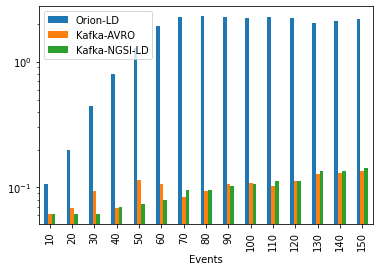

In [71]:
cpu_perf = pd.DataFrame({"Events": events,"Orion-LD": orion_cpu,
                         "Kafka-AVRO": kafka_avro_cpu, "Kafka-NGSI-LD": kafka_ngsi_ld_cpu})
cpu_perf.plot.bar(x="Events")

### Memory Performance

<AxesSubplot:xlabel='Events'>

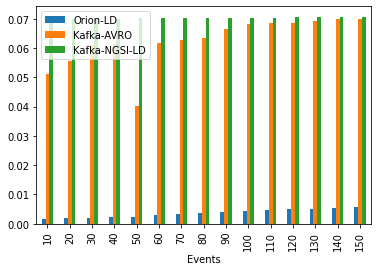

In [48]:
memory_perf = pd.DataFrame({"Events": events,"Orion-LD": orion_memory,
                            "Kafka-AVRO": kafka_avro_memory, "Kafka-NGSI-LD": kafka_ngsi_ld_memory})
memory_perf.plot.bar(x="Events")